In [8]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
from gensim.models import KeyedVectors
import spacy

In [4]:
word2vec = KeyedVectors.load("./../word2vec/word2vec_100_3_polish.bin")

In [5]:
def tokens_to_vector(sentence):
    vector_size = word2vec.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sentence:
        if w in word2vec:
            ctr += 1
            wv_res += word2vec[w]
    wv_res = wv_res/ctr
    return wv_res

In [10]:
spacy_model = spacy.load("pl_core_news_sm")

In [11]:
# Stop words
stop_words = spacy_model.Defaults.stop_words.copy()
stop_words.remove("nie")
print(stop_words)

{'dlatego', 'duzo', 'byly', 'poniewaz', 'innych', 'miedzy', 'ktore', 'przez', 'dokad', 'wie', 'gdzies', 'vii', 'jakkolwiek', 'cala', 'godz', 'ktorego', 'często', 'więcej', 'wami', 'dość', 'ktorzy', 'poza', 'też', 'jego', 'wasza', 'ani', 'bedzie', 'ją', 'tam', 'ty', 'była', 'cię', 'taka', 'aż', 'co', 'powinien', 'także', 'ponad', 'dzis', 'twoja', 'mogą', 'jesli', 'je', 'przeciez', 'nas', 'możliwe', 'wszystkie', 'zapewne', 'ciebie', 'prawie', 'wasze', 'wszystkich', 'pod', 'dobrze', 'może', 'mam', 'cała', 'ten', 'bez', 'jakichś', 'twoi', 'one', 'inny', 'pani', 'totobą', 'moga', 'dziś', 'jednak', 'cie', 'moi', 'ktorych', 'sposób', 'twój', 'xv', 'których', 'żaden', 'sam', 'raz', 'tę', 'gdyż', 'te', 'byla', 'caly', 'ok', 'mi', 'jakoś', 'którzy', 'było', 'znów', 'on', 'oto', 'z', 'dwaj', 'jezeli', 'inne', 'coraz', 'zeby', 'ponieważ', 'niego', 'cali', 'dokąd', 'mozna', 'coś', 'być', 'nasza', 'nimi', 'we', 'ależ', 'ci', 'chce', 'twoje', 'który', 'kilku', 'xiii', 'będę', 'ix', 'tel', 'dwie', 'ic

In [12]:
len(stop_words)

380

In [13]:
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [14]:
# Tokenizer
def spacy_tokenizer(sentence):
    doc = spacy_model(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # Removing stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [18]:
df = pd.read_json('./../../data/translated/sarcasm/sarcasm_headlines_dataset_pl.json')
df = df.drop(columns=['article_link', 'headline'])
df

,is_sarcastic,headline_pl
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,Jedz warzywa: 9 pysznie różnych przepisów
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...
28614,1,Żydzi świętują Rosh Hashasha czy coś
28615,1,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,Mars zniszczony przez pałac kosmiczny na orbic...


In [19]:
texts = df['headline_pl'].to_list()
tokenized_sentences = [spacy_tokenizer(text) for text in texts]

In [20]:
vectors = [tokens_to_vector(tokenized_sentence) for tokenized_sentence in tokenized_sentences]
vectors

[array([-0.73846652, -0.84116657, -0.50757432,  0.9671369 ,  0.24950934,
        -1.17623523,  0.22780913,  0.39508308,  0.22415954, -1.12055134,
         0.16480577,  1.1161645 ,  0.0657818 ,  2.03583793, -0.27109855,
        -1.02742643,  0.32726887, -1.0409012 ,  1.37135752,  0.29635613,
        -1.844759  , -0.6001361 ,  0.31440233, -0.37013197,  1.43974525,
        -0.54148577, -0.28943831, -0.67987111,  1.32633185,  0.13673029,
         0.5846161 , -0.38835723, -1.18891878,  0.25353534, -0.80451939,
        -0.0423151 , -0.51154422,  0.5887251 ,  1.87881334,  0.17082115,
         0.1271016 ,  0.37898287, -0.49231379, -1.89973757, -0.77015079,
         0.43008232, -0.58959402, -2.45455973,  1.00014024, -0.18546487,
        -0.59613536,  0.41398742, -0.06604579, -0.42026662, -0.92616999,
        -1.06169876, -0.17892712,  1.29467155,  0.25769253, -0.47682756,
         1.14440311, -1.09947558, -0.36781857,  0.38303545, -0.04061902,
        -0.63830833, -1.28415614, -1.02597247,  0.2

In [21]:
X = np.array(vectors)
y = df['is_sarcastic'].to_numpy()

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42)

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [23]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

In [24]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [25]:
model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
716/716 [==============================] - 3s 3ms/step - loss: 0.6144 - accuracy: 0.6563 - val_loss: 0.5869 - val_accuracy: 0.7023
Epoch 2/10
716/716 [==============================] - 1s 2ms/step - loss: 0.5712 - accuracy: 0.7029 - val_loss: 0.5763 - val_accuracy: 0.7009
Epoch 3/10
716/716 [==============================] - 1s 2ms/step - loss: 0.5472 - accuracy: 0.7217 - val_loss: 0.5767 - val_accuracy: 0.7032
Epoch 4/10
716/716 [==============================] - 1s 2ms/step - loss: 0.5251 - accuracy: 0.7369 - val_loss: 0.5742 - val_accuracy: 0.7112
Epoch 5/10
716/716 [==============================] - 1s 2ms/step - loss: 0.5011 - accuracy: 0.7544 - val_loss: 0.5891 - val_accuracy: 0.7049
Epoch 6/10
716/716 [==============================] - 1s 2ms/step - loss: 0.4764 - accuracy: 0.7702 - val_loss: 0.5854 - val_accuracy: 0.7105
Epoch 7/10
716/716 [==============================] - 1s 2ms/step - loss: 0.4502 - accuracy: 0.7850 - val_loss: 0.6157 - val_accuracy: 0.6907
Epoch 

In [42]:
import sklearn.metrics as skmetrics
import os
import matplotlib.pyplot as plt

def _create_dirs_if_not_exists(directory):
    if not os.path.isdir(directory):
        os.makedirs(directory)

def plot_and_save_conf_matrix(class_actual, class_preds, figure_dir_path, figure_filename):
    confusion_matrix = skmetrics.confusion_matrix(class_actual, class_preds)
    disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot()

    figure_dir = os.path.join(os.curdir, figure_dir_path)
    _create_dirs_if_not_exists(figure_dir)

    plt.savefig(os.path.join(figure_dir, figure_filename))
    plt.show()

def get_class_preds(model, test_dataset, return_classes=True):
    prediction_logits = model.predict(test_dataset)
    probabilities = tf.nn.softmax(prediction_logits)
    if return_classes:
        return np.argmax(probabilities, axis=1)
    else:
        return probabilities.numpy()

45/45 [==============================] - 0s 1ms/step


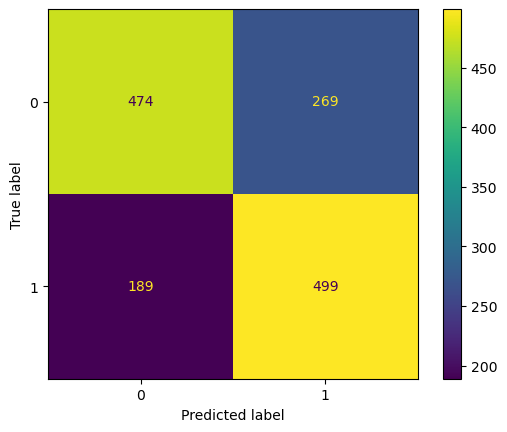

In [43]:
class_preds = get_class_preds(model, X_test)
model_name = 'sarcasm_pl_word2vec_external'
training_name = model_name
figures_dir = f"../../documentation/models/{model_name}/figures"

plot_and_save_conf_matrix(class_actual=y_test,
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")